In [1]:
from models.subunit_nn import Subunit_NN

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
sub_no = C_syn_e.shape[0]

V -= torch.mean(V)

In [3]:
T_train = 9 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 301
H_no = 3
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Subunit_NN(C_syn_e, C_syn_i, T_no, H_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

20072


In [6]:
temp_list = [0.5,0.4,0.3,0.2,0.1,
            0.09,0.08,0.07,0.06,0.05,
            0.04,0.03,0.02,0.01,
            0.009,0.008,0.007,0.006,0.005,
            0.004,0.003,0.002,0.001]
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    temp = temp_list[temp_count]
    if (i%20 == 19) & (temp_count < 22):
        temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(batch_E_neural, batch_I_neural, temp)
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred = model(test_E_neural, test_I_neural, temp)
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, test_score, temp)


<ipython-input-6-3e0eec8adf62>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 0.519848108291626 0.08
199 0.7053191661834717 0.01
299 0.7314894199371338 0.004
399 0.7413318157196045 0.001
499 0.7522929310798645 0.001
599 0.7570080757141113 0.001
699 0.7619925141334534 0.001
799 0.7644484639167786 0.001
899 0.7653843760490417 0.001
999 0.7703633904457092 0.001
1099 0.7718958854675293 0.001
1199 0.7724254131317139 0.001
1299 0.7735914587974548 0.001
1399 0.7754502892494202 0.001
1499 0.775692880153656 0.001



KeyboardInterrupt: 

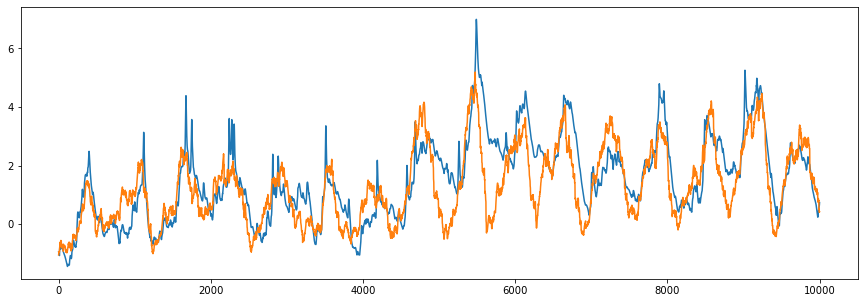

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

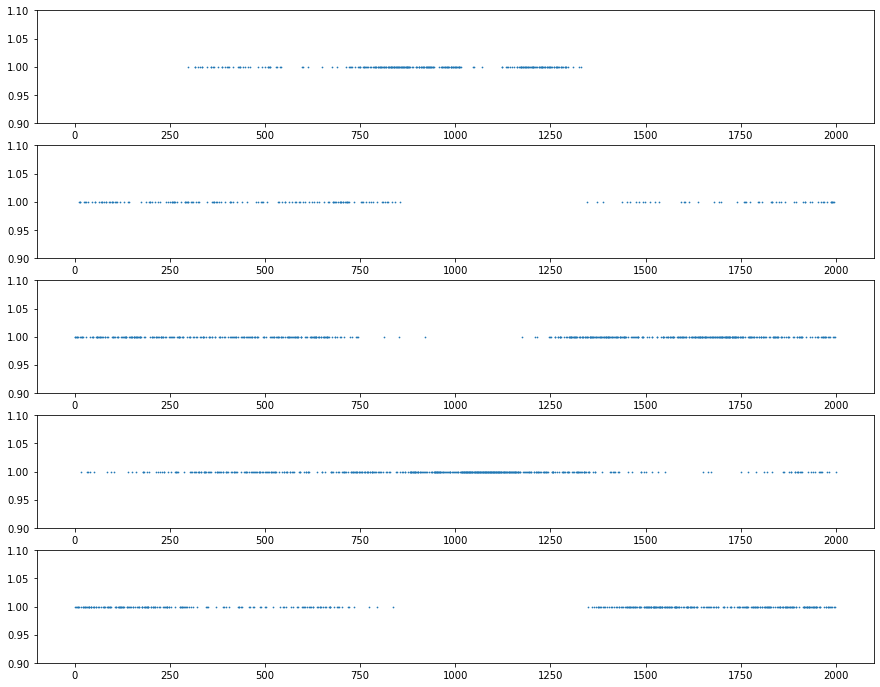

In [13]:
sub_no = 5
fig, axs = plt.subplots(nrows = sub_no, figsize = (15,12))

raw = model.C_syn_e_raw
new = F.softmax(raw/0.001, 0).cpu().detach().numpy()

for i in range(sub_no):
    axs[i].scatter(np.arange(2000),new[i],s=0.5)
    axs[i].set_ylim(0.9,1.1)

